https://tutorials.pytorch.kr/advanced/neural_style_tutorial.html

## 뉴럴 스타일 트랜스퍼

In [1]:
import os
import itertools
import PIL
import copy
import datetime
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision.utils as vutils
from torchvision import datasets
from torchvision.models import vgg19
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
from PIL import Image

from CycleGAN import GeneratorResNet, Discriminator


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda:0 device


In [3]:
data_folder = '../data/neural_style_transfer'
image_save_folder = './images/neural_style_transfer'
model_save_path = './neural_style_transfer.pth'

os.makedirs(image_save_folder, exist_ok=True)

In [4]:
content_image_path = os.path.join(data_folder, 'tubingen.jpg')
style_image_name = 'starry-night.jpg'
style_image_path = os.path.join(data_folder, style_image_name)

content_image = Image.open(content_image_path)
style_image = Image.open(style_image_path)

width, height = content_image.size
img_height = 600
img_width = int(width * img_height / height)

print(img_width, img_height)

800 600


In [5]:
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
])

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    plt.show()

In [6]:
content_image = transform(content_image).unsqueeze(0).to(device)
style_image = transform(style_image).unsqueeze(0).to(device)

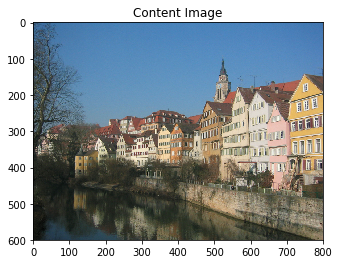

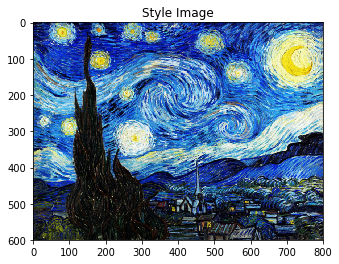

In [7]:
plt.figure()
imshow(content_image, 'Content Image')

plt.figure()
imshow(style_image, 'Style Image')

In [8]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [9]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    
    return G.div(a * b * c * d)

In [10]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [11]:
def total_variation_loss(x):
    a = torch.square(x[:, :, :img_height - 1, :img_width - 1] - x[:, :, 1:, :img_width - 1])
    b = torch.square(x[:, :, :img_height - 1, :img_width - 1] - x[:, :, :img_height - 1, 1:])
    return torch.sum(torch.pow(a + b, 1.25))

In [12]:
cnn = vgg19(pretrained=True).features.to(device).eval()
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [13]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().view(-1, 1, 1)
        self.std = std.clone().view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [14]:
# 콘텐츠 손실에 사용할 층
content_layers = ['conv_4']
# 스타일 손실에 사용할 층
style_layers = ['conv_1', 'conv_3', 'conv_5', 'conv_9', 'conv_13']

def get_style_model_and_losses(cnn, style_img, content_img):
    normalization = Normalization(cnn_normalization_mean, cnn_normalization_std).to(device)
    
    content_losses = []
    style_losses = []
    
    model = nn.Sequential(normalization)
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        
        model.add_module(name, layer)
        
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
            
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
        
    model = model[:(i + 1)]
    
    return model, style_losses, content_losses

In [15]:
num_steps = 900
style_weight = 100000
content_weight = 1
total_variation_weight = 0.005

In [16]:
def run_style_transfer(cnn, content_img, style_img, input_img):
    model, style_losses, content_losses = get_style_model_and_losses(cnn, style_img, content_img)

    # 모델의 매개변수를 제외한 입력을 최적화해야 하므로
    # 이에 맞춰서 requires_grad 값을 갱신합니다.
    input_img.requires_grad_(True)
    model.requires_grad_(False)

    optimizer = optim.LBFGS([input_img])

    run = [0]
    while run[0] <= num_steps:
        def closure():
            # 업데이트 된 입력 이미지의 값을 수정
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            total_variation_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            total_variation_score = total_variation_loss(input_img)

            style_score *= style_weight
            content_score *= content_weight
            total_variation_score *= total_variation_weight

            loss = style_score + content_score + total_variation_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print(f"run {run[0]}:")
                print('Style Loss: {:4f} Content Loss: {:4f} Total Variation Loss: {:4f}'.format(
                    style_score.item(), content_score.item(), total_variation_score.item()))
                imshow(input_img)
                plt.imsave(os.path.join(image_save_folder, f'result_img_{style_image_name}_e_{run[0]}.png'), transforms.ToPILImage()(input_img.squeeze(0).detach().cpu()))

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

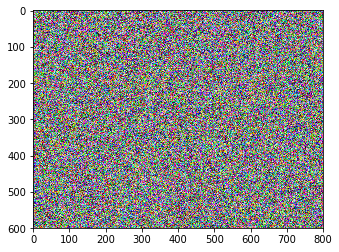

run 100:
Style Loss: 28.176609 Content Loss: 45.404221 Total Variation Loss: 44.218895


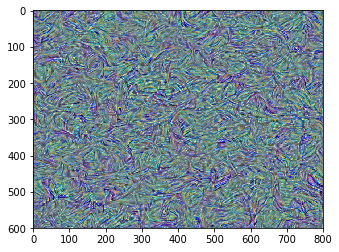

run 200:
Style Loss: 12.677793 Content Loss: 36.087685 Total Variation Loss: 31.707848


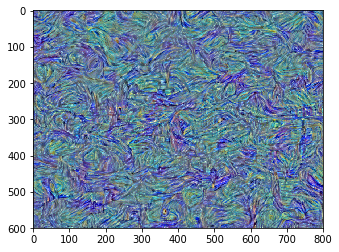

run 300:
Style Loss: 8.927593 Content Loss: 30.982183 Total Variation Loss: 29.513691


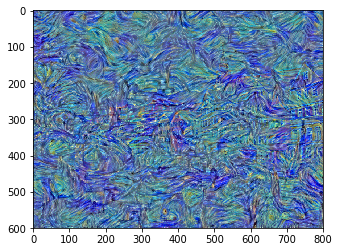

run 400:
Style Loss: 7.748800 Content Loss: 27.888191 Total Variation Loss: 28.740801


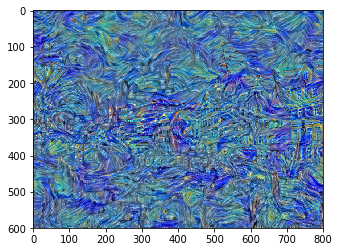

run 500:
Style Loss: 6.799641 Content Loss: 25.753738 Total Variation Loss: 28.541367


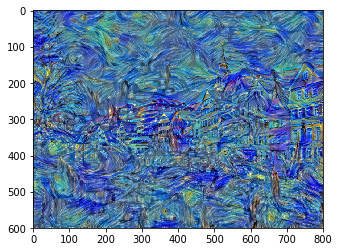

run 600:
Style Loss: 5.910480 Content Loss: 24.493780 Total Variation Loss: 28.325214


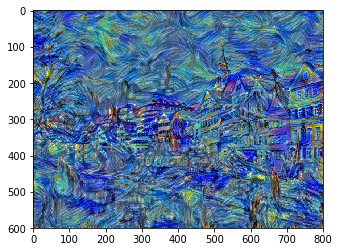

run 700:
Style Loss: 5.461813 Content Loss: 23.809092 Total Variation Loss: 28.140690


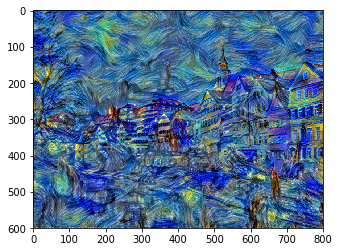

run 800:
Style Loss: 10.553894 Content Loss: 23.964764 Total Variation Loss: 28.646755


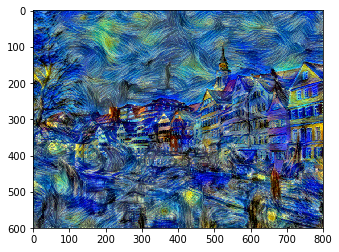

run 900:
Style Loss: 2200.878662 Content Loss: 40.999886 Total Variation Loss: 75.136002


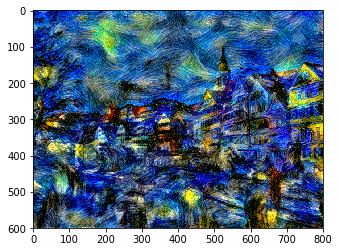

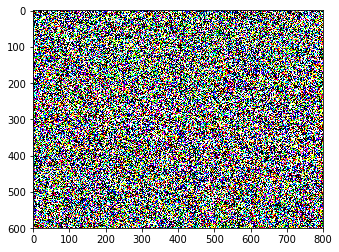

In [17]:
input_image = torch.empty_like(content_image).uniform_(0, 1).to(device)

imshow(input_image)
plt.imsave(os.path.join(image_save_folder, f'input_img.png'), transforms.ToPILImage()(input_image.squeeze(0).detach().cpu()))

output = run_style_transfer(cnn, content_image, style_image, input_image)

plt.figure()
imshow(output)

plt.ioff()
plt.show()